<a href="https://colab.research.google.com/github/nabilLearns/Deeply-Supervised-Nets/blob/master/DSN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get required modules

In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
!pip --quiet install wget

In [ ]:
#import os
#os.path.join(os.getcwd()
print(os.getcwd())
print(os.path.join(os.getcwd(), 'DateData'))

/home/nabil/Documents/Code/Data_Classification
/home/nabil/Documents/Code/Data_Classification/DateData


## Download Dataset

In [ ]:
# Download dataset in an .arff final into current working directory

import wget, requests, io, os, shutil
from zipfile import ZipFile

data_url = "https://www.muratkoklu.com/datasets/vtdhnd06.php"
req = requests.get(data_url)
zip_file = ZipFile(io.BytesIO(req.content))
path = os.path.join(os.getcwd())
zip_file.extractall(path)

shutil.move(os.path.join(os.getcwd(),'Date_Fruit_Datasets/Date_Fruit_Datasets.arff'), os.path.join(os.getcwd(), 'Date_Fruit_Datasets.arff'))
shutil.rmtree(os.path.join(os.getcwd(),'Date_Fruit_Datasets'))


In [ ]:
# Python script that converts .arff to .csv (not mine)
# Source: https://github.com/haloboy777/arfftocsv/blob/master/arffToCsv.py

#########################################
# Project   : ARFF to CSV converter     #
# Created   : 10/01/17 11:08:06         #
# Author    : haloboy777                #
# Licence   : MIT                       #
#########################################

# Importing library
import os

# Getting all the arff files from the current directory
files = [arff for arff in os.listdir('.') if arff.endswith(".arff")]
print(files)

# Function for converting arff list to csv list
def toCsv(text):
    data = False
    header = ""
    new_content = []
    for line in text:
        if not data:
            if "@ATTRIBUTE" in line or "@attribute" in line:
                attributes = line.split()
                if("@attribute" in line):
                    attri_case = "@attribute"
                else:
                    attri_case = "@ATTRIBUTE"
                column_name = attributes[attributes.index(attri_case) + 1]
                header = header + column_name + ","
            elif "@DATA" in line or "@data" in line:
                data = True
                header = header[:-1]
                header += '\n'
                new_content.append(header)
        else:
            new_content.append(line)
    return new_content


# Main loop for reading and writing files
for file in files:
    with open(file, "r") as inFile:
        content = inFile.readlines()
        name, ext = os.path.splitext(inFile.name)
        new = toCsv(content)
        with open(name + ".csv", "w") as outFile:
            outFile.writelines(new)

['Date_Fruit_Datasets.arff']


## Preprocess Data

In [ ]:
data = pd.read_csv("Date_Fruit_Datasets.csv")
print(data.head())

# As you can see, the values need to be normalized

     AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  \
0  422163   2378.908    837.8484    645.6693        0.6373  733.1539   
1  338136   2085.144    723.8198    595.2073        0.5690  656.1464   
2  526843   2647.394    940.7379    715.3638        0.6494  819.0222   
3  416063   2351.210    827.9804    645.2988        0.6266  727.8378   
4  347562   2160.354    763.9877    582.8359        0.6465  665.2291   

   SOLIDITY  CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  KurtosisRR  KurtosisRG  \
0    0.9947       424428  0.7831        1.2976  ...      3.2370      2.9574   
1    0.9974       339014  0.7795        1.2161  ...      2.6228      2.6350   
2    0.9962       528876  0.7657        1.3150  ...      3.7516      3.8611   
3    0.9948       418255  0.7759        1.2831  ...      5.0401      8.6136   
4    0.9908       350797  0.7569        1.3108  ...      2.7016      2.9761   

   KurtosisRB    EntropyRR    EntropyRG    EntropyRB  ALLdaub4RR  ALLdaub4RG  \
0      4.228

### Generate train/val/test data splits

In [ ]:
# Generate train/val/test data splits

#print(data.info())
#print(data['Class'].unique())
#normalized_df=(df-df.mean())/df.std()

normalized = (data - data.mean()) / data.std()
data = normalized
print(normalized)

data['Class'] = data['Class'].astype('category').cat.codes + 1
print(data['Class'].unique())
train, val, test = {}, {}, {}
for date_type in data['Class'].unique(): #['DOKOL']

    num_examples = data[data['Class'] == date_type].shape[0]
    data[data['Class'] == date_type] = data[data['Class'] == date_type].sample(frac=1, random_state=42)

    train[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[0:int(num_examples*0.8)]#.values
    val[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[int(num_examples*0.8):int(num_examples*0.9)]#.values
    test[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[int(num_examples*0.9):]#.values

    print(type(train[date_type]), train[date_type].shape)

#print(len(train))
train, val, test = [pd.concat(split).sample(frac=1, random_state=1).reset_index(drop=True) for split in [train, val, test]]

         AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  \
0    1.154996   0.783506    0.604171    1.310912     -1.128939  1.075105   
1    0.371493   0.067030   -0.187369    0.869305     -1.898713  0.431196   
2    2.131077   1.438330    1.318387    1.920829     -0.992566  1.793104   
3    1.098117   0.715952    0.535671    1.307670     -1.249533  1.030654   
4    0.459385   0.250463    0.091460    0.761039     -1.025251  0.507143   
..        ...        ...         ...         ...           ...       ...   
893 -0.399945  -0.322663   -0.409322   -0.163589     -0.150662 -0.287007   
894  0.630600   1.480838    0.726446    0.487201      0.303539  0.652184   
895 -0.409950  -0.319319   -0.023030   -0.527273      0.846776 -0.297034   
896 -0.553313  -0.369240   -0.237149   -0.472947      0.561632 -0.443100   
897  0.424231   0.564888    0.506956    0.340451      0.261838  0.476892   

     SOLIDITY  CONVEX_AREA    EXTENT  ASPECT_RATIO  ...  KurtosisRR  \
0    0.708233   

### Get data and label tensors from each dataframe split

In [ ]:
# Get data and label tensors from each split dataframe

X_train = torch.Tensor(train.values[:,:-1])
Y_train = torch.Tensor(train.values[:,-1])

X_val = torch.Tensor(val.values[:,:-1])
Y_val = torch.Tensor(val.values[:,-1])

X_test = torch.Tensor(test.values[:,:-1])
Y_test = torch.Tensor(test.values[:,-1])

In [ ]:
X_train.shape

tensor([1., 2., 3., 4., 5., 6., 7.])


## Define Model Architecture and Loss

In [ ]:
# define model
torch.manual_seed(0)

class Network(nn.Module):
    def __init__(self, n_in=34, n_hidden=5, n_classes=7):#, ks, stride):
        super(Network, self).__init__()
        self.mapping1 = nn.Linear(n_in, n_hidden)
        self.mapping2 = nn.Linear(n_hidden, n_hidden)
        self.mapping3 = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()

        self.svm_1 = torch.empty(n_hidden)
        nn.init.uniform_(self.svm_1, -0.01, 0.02)

        self.svm_2 = torch.empty(n_hidden)
        nn.init.normal_(self.svm_2, -0.01, 0.02)

        self.svm_3 = torch.empty(n_classes)
        nn.init.normal_(self.svm_3, -0.01, 0.02)

        #self.w = nn.Parameter(torch.randn(1, 2), requires_grad=True)

    def forward(self, x):
        f_map1 = self.relu(self.mapping1(x))
        f_map2 = self.relu(self.mapping2(f_map1))
        f_map3 = self.mapping3(f_map2)
                
        return [f_map1, f_map2, f_map3, self.svm_1, self.svm_2, self.svm_3]


def companion_loss(f_map, svm_w, t_labels, n_labels=7):
    """
    Implements L2-SVM companion objective loss described by equations (4) and (5) of the "Deeply Supervised Nets" paper ([Gallagher et. al, 2014])

    parameters
    ----------
    f_map: of shape (BATCH_SIZE x NUM_FEATURES)
    svm_w: svm weights
    t_labels: vector of labels
    """

    loss = 0
    all_labels = torch.arange(n_labels) + 1

    f_labels = [all_labels[all_labels != t_labels[i]] for i in range(len(t_labels))] # f_labels.shape = (# examples, 6), each row has labels != t_label
    f_labels = torch.stack(f_labels)

    #print(f_map.shape, svm_w.shape, (f_map@svm_w).shape)
    svm_pred = torch.unsqueeze(f_map @ svm_w, dim=0).T # torch.Size([716, 1])

    # < w^(m), (Z^(m), y) >
    true_label_svm = svm_pred * torch.unsqueeze(t_labels,dim=0).T # torch.Size([716, 1])
    
    # < w^(m), (Z^(m), y_k) > for all k
    f_labels_svm = svm_pred * f_labels # torch.Size([716, 6])

    #print(svm_pred.shape, true_label_svm.shape, f_labels_svm.shape, f_labels.shape)

    loss = torch.sum(torch.nn.functional.relu(1 - (true_label_svm - f_labels_svm))**2)#**2
    
    return loss

#global_loss = lambda data: torch.sum([companion_loss(f_map) for f_map in Network(data)])
def global_loss(model_out: list, Y, alphas: list, gamma = 0.05):
    """
    Return overall combined objective function as specified in eq. (3) of [Gallagher et. al, 2014]
    
    parameters
    ----------
    model_out: [f_map1, f_map2, f_map3, svm1, svm2, svm3]
    alphas: list of alpha values (see eq. (3), and pg. 4 of [Gallagher et. al, 2014])
    gamma: see pg. 4 of [Gallagher et. al, 2014]
    """

    n_layers = len(model_out) // 2
    companion_losses = [companion_loss(model_out[m], model_out[m+n_layers], Y) for m in range(n_layers)]
    
    f_layer_loss = torch.norm(model_out[-1])**2 + companion_losses[-1]
    modified_companion_losses = [alphas[m] * torch.nn.functional.relu(torch.norm(model_out[m + n_layers])**2 + companion_losses[m] - gamma) for m in range(n_layers - 1)]
    global_loss = f_layer_loss + sum(modified_companion_losses)
    
    #print(companion_losses)
    #print("norms: ", torch.norm(model_out[-1]), torch.norm(model_out[-2]))
    return global_loss
    

## Train

In [ ]:
def train(num_epochs = 100):
    opt = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.01)
    epoch_losses = []
    epoch_accs = []

    alphas = [0.1, 0.1]#[14, 10]
    
    for epoch in range(num_epochs):

        avg_train_loss = 0
        train_acc = 0

        if epoch % (int)(num_epochs * 0.2) == 0:
            print(f"EPOCH {epoch}")
            #print(torch.nn.functional.softmax(model(X_train)[1][0:10],dim=1))
            print(torch.argmax(model(X_train)[2][0:10],dim=1))

        batch_sz = 125
        alphas = [a * 0.1 * (1 - epoch / num_epochs) for a in alphas]
        
        for batch_idx in range(0, X_train.shape[0], batch_sz):
            opt.zero_grad()
            L = global_loss(model(X_train[batch_idx:batch_idx+batch_sz]), Y_train[batch_idx:batch_idx+batch_sz], alphas)
            L.backward()
            opt.step()

            avg_train_loss += L.item()

            train_batch_pred = torch.argmax(model(X_train[batch_idx:batch_idx+batch_sz])[2],dim=1) + 1
            train_batch_true = Y_train[batch_idx:batch_idx+batch_sz]
            train_acc += np.array(train_batch_pred == train_batch_true).sum()
        
        epoch_losses.append(avg_train_loss / X_train.shape[0])
        epoch_accs.append(train_acc / X_train.shape[0])

    plt.plot(epoch_losses)
    plt.title("Train Set Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.show()

    plt.plot(epoch_accs)
    plt.title("Train Set Accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch #')
    plt.show()
    
    return epoch_losses, epoch_accs

EPOCH 0
tensor([6, 6, 6, 1, 6, 6, 1, 6, 6, 1])
EPOCH 20
tensor([1, 1, 6, 1, 6, 6, 1, 1, 6, 1])
EPOCH 40
tensor([1, 1, 6, 1, 1, 6, 1, 1, 6, 1])
EPOCH 60
tensor([1, 1, 6, 1, 1, 6, 1, 1, 6, 1])
EPOCH 80
tensor([1, 1, 6, 1, 1, 6, 1, 1, 6, 1])


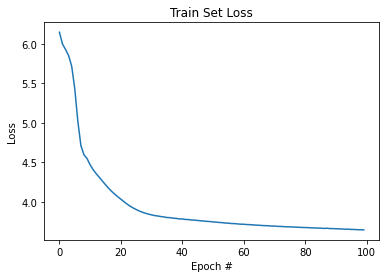

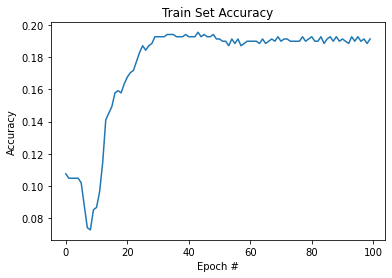

([6.149310831251091,
  6.00003963875371,
  5.93023366235488,
  5.852135088190686,
  5.716434159092397,
  5.431633634940206,
  5.01822709238063,
  4.709834477088971,
  4.594547037305778,
  4.5475304033503186,
  4.467332211286662,
  4.4060330950348074,
  4.354358737029177,
  4.308325613011195,
  4.261422141304229,
  4.215657196897368,
  4.171845334868191,
  4.131626022594601,
  4.095990399408607,
  4.0631084335582885,
  4.032255375185493,
  4.00139912013901,
  3.97116165587356,
  3.9440588072025577,
  3.9211655515532255,
  3.900874430906839,
  3.8825079209311713,
  3.8667701849058354,
  3.8542876003840782,
  3.842838862754779,
  3.833793128668929,
  3.824743601196971,
  3.8198405857192737,
  3.812527960239176,
  3.807616803899158,
  3.8003909574540633,
  3.7982647858518463,
  3.7921840305434924,
  3.7889312232672836,
  3.78293524374509,
  3.781890229805888,
  3.775570533795064,
  3.774533490228919,
  3.7686589416844885,
  3.76733530566679,
  3.762422614923403,
  3.7587774692300977,
  3.7

In [ ]:
model = Network()
train()

### Deprecated code for testing

Examine weights at every layer

In [ ]:
f1, f2, f3, s1, s2, s3 = model(X_train[0:10])

print(f1.shape, s1.shape)
print(f"{f1} \n\n  {f2} \n\n {f3}")

torch.Size([10, 5]) torch.Size([5])
tensor([[2.6562, 3.7774, 0.3459, 1.2566, 0.0000],
        [1.6194, 2.9163, 0.0000, 0.8579, 0.0000],
        [1.1465, 0.0000, 0.0000, 0.6298, 0.4821],
        [1.4496, 4.4364, 0.0000, 1.0822, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.6923, 0.5277, 0.0000, 1.1399, 0.6488],
        [1.9688, 5.2606, 0.0000, 1.1872, 0.0000],
        [1.4789, 4.2494, 1.1399, 0.9333, 0.0000],
        [0.0000, 0.0000, 3.3393, 0.0000, 1.6777],
        [1.4936, 3.9115, 0.0000, 1.0701, 0.0000]], grad_fn=<ReluBackward0>) 

  tensor([[1.5944, 0.0000, 0.0000, 2.2556, 0.0000],
        [1.7080, 0.0000, 0.0000, 1.6231, 0.0000],
        [1.6067, 1.7206, 0.0000, 0.2798, 0.0000],
        [1.6616, 0.0000, 0.0000, 2.1532, 0.0000],
        [1.6646, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.6118, 1.8190, 0.0000, 0.6776, 0.0000],
        [1.6538, 0.0000, 0.0000, 2.6651, 0.0000],
        [1.0944, 0.0000, 0.0000, 1.8052, 0.0000],
        [0.0000, 3.6739, 0.0000, 0

Figure out how to compute accuracy

In [ ]:
predicted = torch.Tensor([[1, 2, 3], [3, 4, 4]])

true = torch.Tensor([[3, 0]])
    
print(predicted, true)
print(np.array(torch.argmax(predicted, dim=1) + 1 == true).sum())

tensor([[1., 2., 3.],
        [3., 4., 4.]]) tensor([[3., 0.]])
1


Previous attempts at defining companion loss

In [ ]:
"""
deprecated code -- alternate ways I tried calculating loss
i = 0
for row in f_labels: # i.e. row = torch.Tensor([0, 2, 3, 4, 5, 6])
    i += 1
    if i % 10 == 0:
        print(i)
    for f_label in row:
        # < w^(m), (Z^(m), y_k) >
        f_label_svm = (f_map @ svm_w) * f_label

        # max(0, 1 - (true_label_svm - f_label_svm))**2
        loss += sum(torch.nn.functional.relu(1 - (true_label_svm - f_label_svm))**2)
"""

"""
for row in f_labels:
    svm_pred = torch.unsqueeze(f_map @ svm_w, dim=0).T # shape = (# examples, 1)
    row = torch.unsqueeze(row, dim=0) # shape = (1, 6)
    f_label_svms = svm_pred.long() @ row
    loss += torch.sum(torch.nn.functional.relu(1 - (true_label_svm.T - f_label_svms))**2)
return loss
    #true_label_svm = torch.unsqueeze((f_map @ svm_w) * t_labels, dim=0).T # torch.Size([716, 1]) 
"""


'\nfor row in f_labels:\n    svm_pred = torch.unsqueeze(f_map @ svm_w, dim=0).T # shape = (# examples, 1)\n    row = torch.unsqueeze(row, dim=0) # shape = (1, 6)\n    f_label_svms = svm_pred.long() @ row\n    loss += torch.sum(torch.nn.functional.relu(1 - (true_label_svm.T - f_label_svms))**2)\nreturn loss\n    #true_label_svm = torch.unsqueeze((f_map @ svm_w) * t_labels, dim=0).T # torch.Size([716, 1]) \n'

Examining initial loss values

In [ ]:
# test loss

f1, f2, f3, svm1, svm2, svm3 = model(X_train)

loss_1 = companion_loss(f1, svm1, Y_train)
loss_2 = companion_loss(f2, svm2, Y_train)
loss_3 = companion_loss(f3, svm3, Y_train)

global_loss(model(X_train), Y_train, alphas=[0.1, 0.2, 0.3])

tensor(5558.4961, grad_fn=<AddBackward0>)

Get familiar with re-shaping of input needed in loss function

In [ ]:
"""
Re-shaping is needed in companion_loss() because in class Network.forward(), svm weights are defined to be 1 dimension i.e. (#dim,) instead of (#dim,1).
We didn't realize this before, so we did re-shaping of svm weights in the loss function.  Properly defining weights in the forward() could work, but then we'd have to
change up the re-shaping stuff in the loss function
"""

a = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8, 10])
a = torch.unsqueeze(a, dim=0)

true = torch.ones(a.shape)

f = torch.Tensor([0, -1, 2])
f = torch.unsqueeze(f, dim=0)

m = (a.T @ f)

print(a.shape, f.shape, true.shape)
print(m, m.shape)
print(1 - (true.T - m))
print(sum(torch.nn.functional.relu(1 - (true.T - m))**2))

torch.Size([1, 9]) torch.Size([1, 3]) torch.Size([1, 9])
tensor([[  0.,  -1.,   2.],
        [  0.,  -2.,   4.],
        [  0.,  -3.,   6.],
        [  0.,  -4.,   8.],
        [  0.,  -5.,  10.],
        [  0.,  -6.,  12.],
        [  0.,  -7.,  14.],
        [  0.,  -8.,  16.],
        [  0., -10.,  20.]]) torch.Size([9, 3])
tensor([[  0.,  -1.,   2.],
        [  0.,  -2.,   4.],
        [  0.,  -3.,   6.],
        [  0.,  -4.,   8.],
        [  0.,  -5.,  10.],
        [  0.,  -6.,  12.],
        [  0.,  -7.,  14.],
        [  0.,  -8.,  16.],
        [  0., -10.,  20.]])
tensor([   0.,    0., 1216.])


Broadcasting multiplication of the vector of predicted svm values and the 6 vectors of false labels

In [ ]:
j = torch.cat([a] * 3, dim=0) #.squeeze(dim=1)

print(a.T.shape, j.T.shape)

print(a.T)
print(j.T)
print(a.T * j.T)

torch.Size([9, 1]) torch.Size([9, 3])
tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [10.]])
tensor([[ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [10., 10., 10.]])
tensor([[  1.,   1.,   1.],
        [  4.,   4.,   4.],
        [  9.,   9.,   9.],
        [ 16.,  16.,  16.],
        [ 25.,  25.,  25.],
        [ 36.,  36.,  36.],
        [ 49.,  49.,  49.],
        [ 64.,  64.,  64.],
        [100., 100., 100.]])


In [ ]:
svm_w = torch.randn(f1.shape[1])

g = f1 @ svm_w
g = torch.unsqueeze(g, dim=0).T

print(torch.unsqueeze(torch.Tensor([1, 2, 3]), dim=0).shape)

g @ torch.unsqueeze(torch.Tensor([1, 2]), dim=0)

torch.Size([1, 3])


tensor([[-3.5995e+09, -7.1990e+09],
        [-4.6115e+09, -9.2229e+09],
        [-1.0095e+10, -2.0191e+10],
        ...,
        [-3.0495e+09, -6.0990e+09],
        [-3.0662e+09, -6.1324e+09],
        [-4.7045e+09, -9.4091e+09]], grad_fn=<MmBackward0>)